In [11]:
import cPickle as cp
import numpy as np
import matplotlib.pyplot as plt

X, y = cp.load(open('data/winequality-white.cPickle', 'rb'))

N, D = X.shape
N_train = int(0.8 * N)
N_test = N - N_train
X_train = X[:N_train]
y_train = y[:N_train]
X_test = X[N_train:]
y_test = y[N_train:]

report_string = "{}\nTrain: {:.5f}\nTest:  {:.5f}"

# Exercise 1

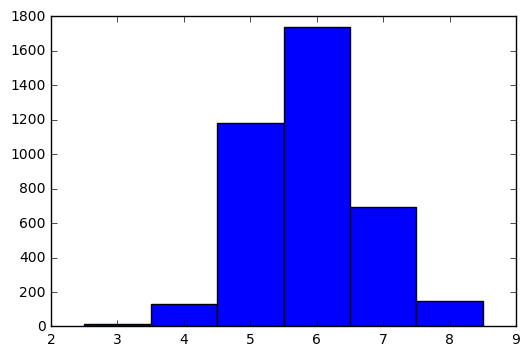

In [2]:
y_range = range(int(y.min()),int(y.max()))
y_count = [(y_train == i).sum() for i in y_range]
plt.bar(np.array(y_range)-.5, y_count, width=1)
plt.show()

# Exercise 2

In [3]:
def mse(actual, model): 
  return np.mean((actual-model)**2)

mean_model = np.mean(y_train)
print(report_string.format("Average", mse(y_train, mean_model), mse(y_test, mean_model)))

Average
Train: 0.79542
Test:  0.73940


# Exercise 3

In [4]:
def leastSquaresModel(count):
  train = X_train[:count]
  test = X_test

  # Normalize features
  mean = np.mean(train, axis=0)
  stddev = np.std(train, axis=0)
  train = (train-mean)/stddev
  test = (test-mean)/stddev

  # Add const 1 feature
  train = np.insert(train, 0, 1, axis = 1)
  test = np.insert(test, 0, 1, axis = 1)

  # w = (X^T.X)^-1.X^T.y
  w = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(train), train)), np.transpose(train)), y_train[:count])

  # do we test on the whole training set or just the things we trained on?
  training_error = mse(y_train[:count], np.dot(train, w))
  testing_error = mse(y_test, np.dot(test, w))

  return count, training_error, testing_error

count, training_error, testing_error = leastSquaresModel(N_train)
print(report_string.format("Least squares", training_error, testing_error))

Least squares
Train: 0.56559
Test:  0.55503


# Exercise 4

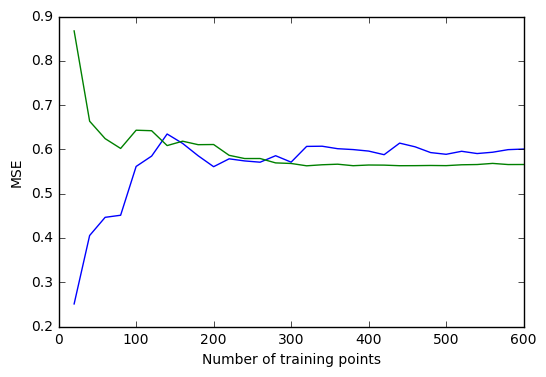

In [5]:
graph = [np.asarray(leastSquaresModel(i)) for i in np.arange(20, 601, 20)]

graph = np.transpose(graph)

plt.plot(graph[0], graph[1])
plt.plot(graph[0], graph[2])
plt.ylabel("MSE")
plt.xlabel("Number of training points")
plt.show()

# Optional

In [6]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import make_pipeline
import warnings; warnings.filterwarnings("ignore")
from math import pow

N_optimization = N_train / 5 * 4

This function chains a normalizer with a basis expander and the supplied linear model, and then returns the training and test error on the supplied data sets:

In [7]:
def predict(method, training, testing, lambda_exp, degree):
  scaler = StandardScaler()
  basis_expander = PolynomialFeatures(degree=degree, include_bias=True)
  model = method(alpha=pow(10, lambda_exp))
  pipeline = make_pipeline(scaler, basis_expander, model)
  pipeline.fit(X[:training], y[:training])

  training_error = mse(y[:training], pipeline.predict(X[:training]))
  testing_error = mse(y[training:testing], pipeline.predict(X[training:testing]))
  return training_error, testing_error

We can now optimise the hyperparameters by using a validation set (```X[N_optimization:N_train]```)

In [8]:
def find_params(method):
  return min(
    [(predict(method, N_optimization, N_train, lambda_exp, degree)[1], lambda_exp, degree) 
    for lambda_exp in range(-5,6)                          
    for degree in range(2,5)]
  )[1:]

hyperparams = {model: find_params(model) for model in [Ridge, Lasso]}

print("Lasso: λ = 10e{}, degree = {}".format(*hyperparams[Lasso]))
print("Ridge: λ = 10e{}, degree = {}".format(*hyperparams[Ridge]))

Lasso: λ = 10e-3, degree = 2
Ridge: λ = 10e1, degree = 2


In [9]:
print(report_string.format("Lasso", *predict(Lasso, N_train, N, *hyperparams[Lasso])))

Lasso
Train: 0.49799
Test:  0.50010


In [10]:
print(report_string.format("Ridge", *predict(Ridge, N_train, N, *hyperparams[Lasso])))

Ridge
Train: 0.49706
Test:  0.50170
